# Lab 5
## Author: Yakovlev Konstantin

### Description

Consider the following bi-level optimization problem:
* L_train = |h + w|^2
* L_val = |w|^2

Optimize hyperparameters using hypernetworks (h is sampled).
Visualize dependency of w on w on the two surface plots: (h, w, L_train), (h, w, L_val).
   * [Hypernetworks](http://www.ipiran.ru/journal/issues/2021_15_01/Vol15_Issue1.pdf)

### Theory

The goal is to obtain a neural network that outputs approximately optimal weights as a function of hyperparameters (best-response). Thus, we use a hypergradient descent
given such a network. The following insight helps us to formulate an optimization problem for training the best-response:

__Theorem__ Sufficiently powerful hypernetworks $w_\varphi(\lambda)$ can learn continuous best-response functions, which minimizes the expected loss for all hyperparameter distributions with convex support.

Formulate the corresponding optimization problem:
$$\varphi^* = \arg\min_{\varphi}\mathbb{E}_{\lambda}\mathcal{L}_{train}(w_\varphi(\lambda), \lambda)$$


### Experimental setup

1. $p(\lambda) = U[-2.5, 2.5]$.
2. $w_\varphi(\lambda)$ is a 2-layer MLP with __tanh__ activation
3. First, we train a hypernetwork. Second, we perform a hypergradient descent.
4. We compare $w_{\varphi^*}(\lambda)$ with analytical solution $w^*(\lambda)$ and then compare the objectives $\mathcal{L}_{val}(w_{\varphi^*}(\lambda), \lambda)$ and $\mathcal{L}_{val}(w^*(\lambda), \lambda)$.

In [1]:
! pip install -q jaxlib jax flax

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from flax import linen as nn

In [3]:
def l_train(w, h):
    return ((w + h) ** 2).sum()


def l_val(w, h):
    return (w ** 2).sum()


class Hypernetwork(nn.Module):
    def setup(self):
        self.lin1 = nn.Dense(5)
        self.act = nn.activation.tanh
        self.lin2 = nn.Dense(4)

    def __call__(self, h):
        return self.lin2(self.act(self.lin1(h))).sum()


@partial(jax.jit, static_argnums=1)
def phi_step(xi, hyp_net, h_params, h):
    """Performs hypernetwork training step

    Arguments:
    xi -- learning rate
    hyp_net -- hypernetwork
    h_params -- its parameters
    h -- sampled hyperparameters

    Returns: updated parameters of the hypernetwork
    """
    w_star = hyp_net.apply(h_params, h)
    grads = jax.grad(lambda p: l_train(hyp_net.apply(p, h), h))(h_params)
    updates = jax.tree_util.tree_map(lambda g: -g * xi, grads)
    return jax.tree_util.tree_map(lambda p, u: p + u, h_params, updates)


@partial(jax.jit, static_argnums=1)
def h_step(xi, hyp_net, h_params, h):
    """Performs a step of a hypergradinet descent

    Arguments:
    xi -- learning rate
    hyp_net -- hypernetwork
    h_params -- its parameters
    h -- hyperparameters

    Returns: updated hyperparameters
    """
    grads = jax.grad(lambda a: l_val(hyp_net.apply(h_params, a), a))(h)
    return h - xi * grads


In [4]:
hyp_net = Hypernetwork()
key = jax.random.PRNGKey(0)
h_params = hyp_net.init(key, jnp.array(0.5).reshape(-1))
T = 200

### Hypernetwork training

In [5]:
key = jax.random.PRNGKey(0)
for _ in range(T):
    key, _ = jax.random.split(key)
    h = jax.random.uniform(key, (1,)) * 5 - 2.5
    h_params = phi_step(1e-2, hyp_net, h_params, h)

In [6]:
w_arr = []
h_arr = np.linspace(-2.5, 2.5)
for h in h_arr:
    w_star = hyp_net.apply(h_params, jnp.array(h).reshape(-1))
    w_arr.append(w_star.item())

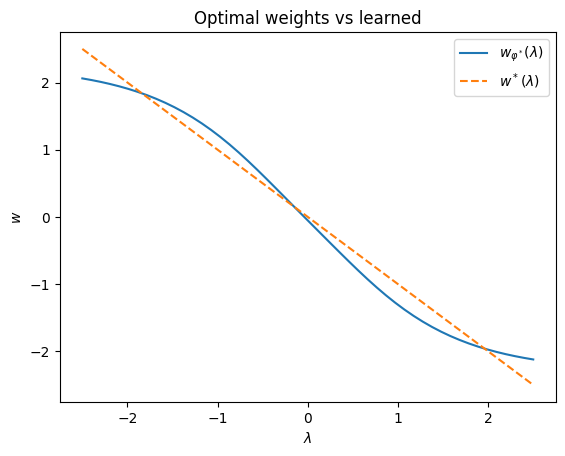

In [7]:
plt.plot(h_arr, w_arr, label=r'$w_{\varphi^*}(\lambda)$')
plt.plot(h_arr, -h_arr, '--', label=r'$w^*(\lambda)$')
plt.legend()
plt.title(r'Optimal weights vs learned')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$w$')
plt.show()

### Hypergradinet descent

In [8]:
key = jax.random.PRNGKey(0)
h = jnp.array(1.0).reshape(-1)
h_arr = [h.item()]
for _ in range(T):
    h = h_step(1e-2, hyp_net, h_params, h)
    h_arr.append(h.item())
sol = h_arr[-1]

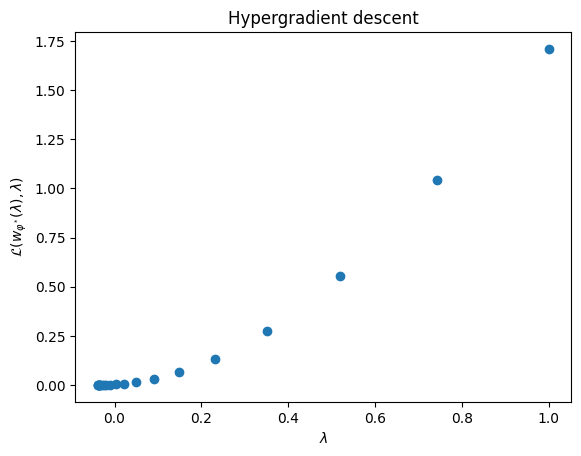

In [9]:
plt.scatter(h_arr[::10],
            [l_val(hyp_net.apply(h_params, jnp.array(h).reshape(-1)),
                   jnp.array(h).reshape(-1)).item() for h in h_arr[::10]])
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\mathcal{L}(w_{\varphi^*}(\lambda), \lambda)$')
plt.title('Hypergradient descent')
plt.show()

### Comparison of the solutions

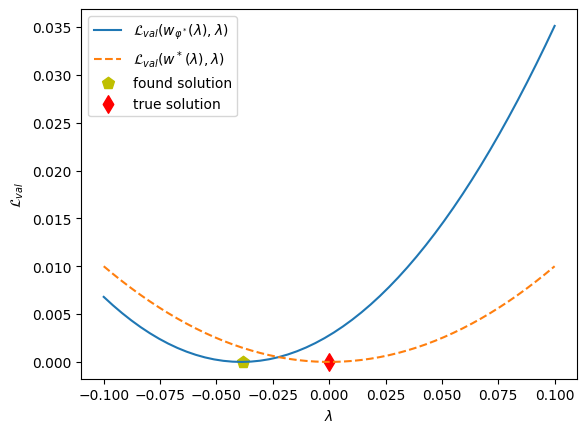

In [12]:
h_arr = jnp.linspace(-0.1, 0.1)
plt.plot(h_arr,
         [l_val(hyp_net.apply(h_params, jnp.array(h).reshape(-1)),
                jnp.array(h).reshape(-1)).item() for h in h_arr],
         label=r'$\mathcal{L}_{val}(w_{\varphi^*}(\lambda), \lambda)$')
plt.plot(h_arr, (h_arr ** 2), '--',
         label=r'$\mathcal{L}_{val}(w^*(\lambda), \lambda)$')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\mathcal{L}_{val}$')
plt.scatter(sol, l_val(hyp_net.apply(h_params, jnp.array(sol).reshape(-1)),
                jnp.array(sol).reshape(-1)).item(), marker='p',
            color='y', s=80, label='found solution')
plt.scatter(0, 0, color='r', marker='d', s=80, label='true solution')
plt.legend()
plt.show()

## Conclusion

1. We see that the hypernetwork to some extent has learned a best-responce
function. Despite the fact that the conditions of the theorem are satisfied,
we do not observe an exact match. We hypothesize that the discrepancy is due to the fact that __tanh__ has vanishing gradients.

2. We also see that the found solution differs from the original. This happens
due to the suboptimality of the first step.